In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
kidiq_url = 'https://raw.githubusercontent.com/cbrownley/NYU-Python-Workshop/main/data/kidiq.csv'
kidiq = pd.read_csv(kidiq_url)
kidiq

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27
...,...,...,...,...,...
429,94,0,84.877412,4,21
430,76,1,92.990392,4,23
431,50,0,94.859708,2,24
432,88,1,96.856624,2,21


In [4]:
# Create a centered version of the mom_iq variable
kidiq['mom_iq_c'] = kidiq['mom_iq'] - kidiq['mom_iq'].mean()
kidiq

,kid_score,mom_hs,mom_iq,mom_work,mom_age,mom_iq_c
0,65,1,121.117529,4,27,21.117529
1,98,1,89.361882,4,25,-10.638118
2,85,1,115.443165,4,27,15.443165
3,83,1,99.449639,3,25,-0.550361
4,115,1,92.745710,4,27,-7.254290
...,...,...,...,...,...,...
429,94,0,84.877412,4,21,-15.122588
430,76,1,92.990392,4,23,-7.009608
431,50,0,94.859708,2,24,-5.140292
432,88,1,96.856624,2,21,-3.143376


## Using statsmodels

In [5]:
# Fit regression model using centered version of mom_iq
fit1 = smf.ols('kid_score ~ 1 + mom_hs + mom_iq_c', data=kidiq).fit()

# Inspect results
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     58.72
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           2.79e-23
Time:                        23:48:23   Log-Likelihood:                -1872.0
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     431   BIC:                             3762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.1221      1.944     42.250      0.0

In [6]:
# SOURCE: https://www.statsmodels.org/stable/gettingstarted.html
# Tools: add_constant https://www.statsmodels.org/stable/api.html

y = kidiq['kid_score']
X = kidiq[['mom_hs', 'mom_iq_c']]
X = sm.add_constant(X)

# Describe regression model
model1 = sm.OLS(y,X)

# Fit regression model
res1 = model1.fit()

# Inspect results
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     58.72
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           2.79e-23
Time:                        23:48:27   Log-Likelihood:                -1872.0
No. Observations:                 434   AIC:                             3750.
Df Residuals:                     431   BIC:                             3762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.1221      1.944     42.250      0.0

In [7]:
features = res1.params.index
coefs = [round(val, 3) for val in res1.params.values]

dict(zip(features, coefs))

{'const': 82.122, 'mom_hs': 5.95, 'mom_iq_c': 0.564}

In [8]:
print("In-sample R-squared: %.3f" % round(res1.rsquared, 3))

In-sample R-squared: 0.214


In [9]:
print("In-sample R-squared (Adj): %.3f" % round(res1.rsquared_adj, 3))

In-sample R-squared (Adj): 0.210


In [10]:
print("In-sample RMSE: %.3f" % round(np.mean((y - res1.fittedvalues)**2)**0.5, 3))

In-sample RMSE: 18.073


In [11]:
# SOURCE: https://www.statology.org/matplotlib-abline/
def abline(intercept, slope, **params):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', **params)

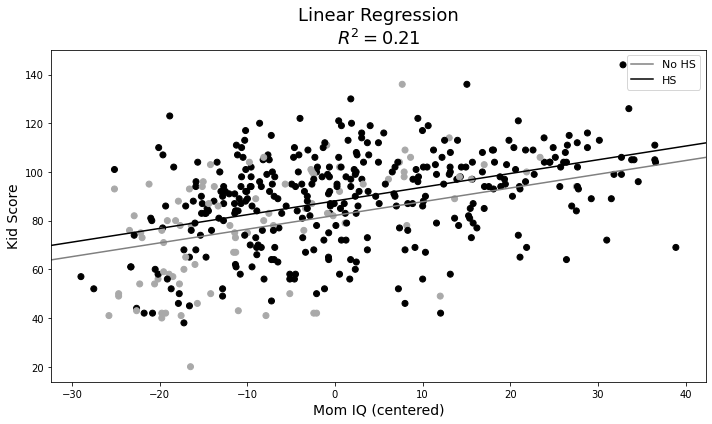

In [18]:
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.graphics.regressionplots.abline_plot.html
fig, ax = plt.subplots(figsize=(10, 6))

colors = {1:'black', 0:'darkgray'}
b_hat = fit1.params

ax.scatter(kidiq.mom_iq_c, kidiq.kid_score, color=kidiq.mom_hs.map(colors))
# abline(b_hat['Intercept'],                 b_hat['mom_iq_c'], color='gray',  label='No HS')
# abline(b_hat['Intercept']+b_hat['mom_hs'], b_hat['mom_iq_c'], color='black', label='HS')
sm.graphics.abline_plot(intercept=b_hat['Intercept'],                 slope=b_hat['mom_iq_c'], color='gray',  label='No HS', ax=ax)
sm.graphics.abline_plot(intercept=b_hat['Intercept']+b_hat['mom_hs'], slope=b_hat['mom_iq_c'], color='black', label='HS',    ax=ax)
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ (centered)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit1.rsquared_adj, fontsize=18)

fig.tight_layout();

## K-fold cross validation using statsmodels and scikit-learn

#### R-squared

In [ ]:
len(y), round(len(y)*(4/5))

(434, 347)

In [21]:
y = kidiq['kid_score']

X = kidiq[['mom_hs', 'mom_iq_c']]
X = sm.add_constant(X)

X[:5]

,const,mom_hs,mom_iq_c
0,1.0,1,21.117529
1,1.0,1,-10.638118
2,1.0,1,15.443165
3,1.0,1,-0.550361
4,1.0,1,-7.254290


In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123) # scikit-learn

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):     # scikit-learn
    res1 = sm.OLS(y[train], X.loc[train,:]).fit()         # statsmodels
    preds = res1.predict(X.loc[test,:])                   # statsmodels
    score = r2_score(y[test], preds)                      # scikit-learn
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample R-squared: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV R-squared: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, Out-of-sample R-squared: 0.205
Fold:  2, Training size: 347, Out-of-sample R-squared: 0.070
Fold:  3, Training size: 347, Out-of-sample R-squared: 0.302
Fold:  4, Training size: 347, Out-of-sample R-squared: 0.137
Fold:  5, Training size: 348, Out-of-sample R-squared: 0.264

CV R-squared: 0.196 (+/- 0.084)


#### RMSE

In [25]:
y = kidiq['kid_score']

X = kidiq[['mom_hs', 'mom_iq_c']]
X = sm.add_constant(X)

X[:5]

,const,mom_hs,mom_iq_c
0,1.0,1,21.117529
1,1.0,1,-10.638118
2,1.0,1,15.443165
3,1.0,1,-0.550361
4,1.0,1,-7.254290


In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)      # scikit-learn

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):          # scikit-learn
    res1 = sm.OLS(y[train], X.loc[train,:]).fit()              # statsmodels
    preds = res1.predict(X.loc[test,:])                        # statsmodels
    score = mean_squared_error(y[test], preds, squared=False)  # scikit-learn
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample RMSE: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, Out-of-sample RMSE: 18.394
Fold:  2, Training size: 347, Out-of-sample RMSE: 18.640
Fold:  3, Training size: 347, Out-of-sample RMSE: 17.431
Fold:  4, Training size: 347, Out-of-sample RMSE: 18.849
Fold:  5, Training size: 348, Out-of-sample RMSE: 17.594

CV RMSE: 18.182 (+/- 0.567)


# Exercise

## 1a. Create an interaction term between `mom_hs` and `mom_iq_c`
## 1b. Run **5**-fold cross-validation on the expanded model that includes `mom_hs`, `mom_iq_c`, and `mom_hs`*`mom_iq_c`
## 1c. Run 10-fold cross-validation on the expanded model, using `RMSE` as the evaluation metric

In [30]:
y = kidiq['kid_score']

kidiq['mom_hs_iq_c'] = kidiq['mom_hs'] * kidiq['mom_iq_c']

X = kidiq[['mom_hs', 'mom_iq_c', 'mom_hs_iq_c']]
X = sm.add_constant(X)

X[-5:]

,const,mom_hs,mom_iq_c,mom_hs_iq_c
429,1.0,0,-15.122588,-0.000000
430,1.0,1,-7.009608,-7.009608
431,1.0,0,-5.140292,-0.000000
432,1.0,1,-3.143376,-3.143376
433,1.0,1,-8.746664,-8.746664


In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):
    res1 = sm.OLS(y[train], X.loc[train,:]).fit()
    preds = res1.predict(X.loc[test,:])
    score = r2_score(y[test], preds)
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample R-squared: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV R-squared: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, Out-of-sample R-squared: 0.224
Fold:  2, Training size: 347, Out-of-sample R-squared: 0.103
Fold:  3, Training size: 347, Out-of-sample R-squared: 0.322
Fold:  4, Training size: 347, Out-of-sample R-squared: 0.103
Fold:  5, Training size: 348, Out-of-sample R-squared: 0.290

CV R-squared: 0.208 (+/- 0.092)


In [29]:
kfold = KFold(n_splits=10, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):
    res1 = sm.OLS(y[train], X.loc[train,:]).fit()
    preds = res1.predict(X.loc[test,:])
    score = mean_squared_error(y[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample RMSE: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 390, Out-of-sample RMSE: 18.557
Fold:  2, Training size: 390, Out-of-sample RMSE: 17.975
Fold:  3, Training size: 390, Out-of-sample RMSE: 19.506
Fold:  4, Training size: 390, Out-of-sample RMSE: 16.829
Fold:  5, Training size: 391, Out-of-sample RMSE: 18.527
Fold:  6, Training size: 391, Out-of-sample RMSE: 16.476
Fold:  7, Training size: 391, Out-of-sample RMSE: 20.745
Fold:  8, Training size: 391, Out-of-sample RMSE: 16.658
Fold:  9, Training size: 391, Out-of-sample RMSE: 17.683
Fold: 10, Training size: 391, Out-of-sample RMSE: 17.010

CV RMSE: 17.997 (+/- 1.302)


## Kfold cross validation "by hand"

#### R-squared

In [ ]:
y = kidiq['kid_score'].values
X = kidiq[['mom_hs', 'mom_iq_c']]
X = sm.add_constant(X)
X = X.values

n_samples = len(y)
indices = np.arange(n_samples)

n_splits = 5
num_val_samples = np.full(n_splits, n_samples // n_splits, dtype=int)
num_val_samples[: n_samples % n_splits] += 1

scores = []
for i in range(n_splits):
    #print('Fold: {:2d}'.format(i+1))
    start =  i      * num_val_samples[i]
    stop  = (i + 1) * num_val_samples[i]
    #print(start, stop)
    y_test = y[indices[start:stop]]
    X_test = X[indices[start:stop], :]
    #print(indices[start:stop])
    #print(y_test.shape, X_test.shape)
    y_train = np.concatenate([ y[indices[:start]] , 
                               y[indices[stop:]] ] , axis=0)
    X_train = np.concatenate([ X[indices[:start], :] , 
                               X[indices[stop:], :] ] , axis=0)
    #print(np.concatenate([ indices[:start], indices[stop:] ]))
    #print(y_train.shape, X_train.shape)

    res1 = sm.OLS(y_train, X_train).fit()
    score = res1.rsquared
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample R-squared: {:.3f}'.format(i+1, len(y_train), score))

print('\nCV R-squared: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, Out-of-sample R-squared: 0.252
Fold:  2, Training size: 347, Out-of-sample R-squared: 0.185
Fold:  3, Training size: 347, Out-of-sample R-squared: 0.205
Fold:  4, Training size: 347, Out-of-sample R-squared: 0.196
Fold:  5, Training size: 348, Out-of-sample R-squared: 0.228

CV R-squared: 0.213 (+/- 0.024)


#### RMSE

In [ ]:
y = kidiq['kid_score'].values
X = kidiq[['mom_hs', 'mom_iq_c']]
X = sm.add_constant(X)
X = X.values

n_samples = len(y)
indices = np.arange(n_samples)

n_splits = 5
num_val_samples = np.full(n_splits, n_samples // n_splits, dtype=int)
num_val_samples[: n_samples % n_splits] += 1

scores = []
for i in range(n_splits):
    #print('Fold: {:2d}'.format(i+1))
    start =  i      * num_val_samples[i]
    stop  = (i + 1) * num_val_samples[i]
    #print(start, stop)
    y_test = y[indices[start:stop]]
    X_test = X[indices[start:stop], :]
    #print(indices[start:stop])
    #print(y_test.shape, X_test.shape)
    y_train = np.concatenate([ y[indices[:start]] , 
                               y[indices[stop:]] ] , axis=0)
    X_train = np.concatenate([ X[indices[:start], :] , 
                               X[indices[stop:], :] ] , axis=0)
    #print(np.concatenate([ indices[:start], indices[stop:] ]))
    #print(y_train.shape, X_train.shape)

    res1 = sm.OLS(y_train, X_train).fit()
    preds = res1.predict(X_test)
    score = np.mean((y_test - preds)**2)**0.5
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, RMSE: {:.3f}'.format(i+1, len(y_train), score))

print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, RMSE: 18.242
Fold:  2, Training size: 347, RMSE: 17.234
Fold:  3, Training size: 347, RMSE: 15.566
Fold:  4, Training size: 347, RMSE: 23.994
Fold:  5, Training size: 348, RMSE: 18.744

CV RMSE: 18.756 (+/- 2.835)


## Using scikit-learn

In [ ]:
y = kidiq['kid_score']
y

0       65
1       98
2       85
3       83
4      115
      ... 
429     94
430     76
431     50
432     88
433     70
Name: kid_score, Length: 434, dtype: int64

In [ ]:
X = kidiq[['mom_hs', 'mom_iq_c']]
X

,mom_hs,mom_iq_c
0,1,21.117529
1,1,-10.638118
2,1,15.443165
3,1,-0.550361
4,1,-7.254290
...,...,...
429,0,-15.122588
430,1,-7.009608
431,0,-5.140292
432,1,-3.143376


In [ ]:
# Create linear regression object
lm1 = LinearRegression().fit(X, y)
lm1

LinearRegression()

In [ ]:
# The coefficients
#print("Coefficients: \n", [round(val,1) for val in reg.coef_.extend(reg.intercept_)]
coefs = [round(val, 3) for val in list(np.concatenate((lm1.intercept_, lm1.coef_), axis=None))]
features = list(np.concatenate((np.array('Intercept'), lm1.feature_names_in_), axis=None))

dict(zip(features, coefs))

{'Intercept': 82.122, 'mom_hs': 5.95, 'mom_iq_c': 0.564}

In [ ]:
# The in-sample coefficient of determination: 1 is perfect prediction
print("In-sample R-squared: %.3f" % round(lm1.score(X, y), 3))

In-sample R-squared: 0.214


In [ ]:
print("In-sample RMSE: %.3f" % round(mean_squared_error(y, lm1.predict(X), squared=False), 3))

In-sample RMSE: 18.073


## Cross validation using scikit-learn

#### R-squared

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):
    lm1.fit(X.loc[train,:], y[train])
    score = lm1.score(X.loc[test,:], y[test])
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample R-squared: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV R-squared: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, Out-of-sample R-squared: 0.205
Fold:  2, Training size: 347, Out-of-sample R-squared: 0.070
Fold:  3, Training size: 347, Out-of-sample R-squared: 0.302
Fold:  4, Training size: 347, Out-of-sample R-squared: 0.137
Fold:  5, Training size: 348, Out-of-sample R-squared: 0.264

CV R-squared: 0.196 (+/- 0.084)


#### RMSE

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):
    lm1.fit(X.loc[train,:], y[train])
    preds = lm1.predict(X.loc[test,:])
    score = mean_squared_error(y[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample RMSE: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, Training size: 347, Out-of-sample RMSE: 18.394
Fold:  2, Training size: 347, Out-of-sample RMSE: 18.640
Fold:  3, Training size: 347, Out-of-sample RMSE: 17.431
Fold:  4, Training size: 347, Out-of-sample RMSE: 18.849
Fold:  5, Training size: 348, Out-of-sample RMSE: 17.594

CV RMSE: 18.182 (+/- 1.268)


# Exercise

## 1a. Create an interaction term between `mom_hs` and `mom_iq_c`
## 1b. Run **5**-fold cross-validation on the expanded model that includes `mom_hs`, `mom_iq_c`, and `mom_hs`*`mom_iq_c`
## 1c. Run 10-fold cross-validation on the expanded model, using `RMSE` as the evaluation metric

In [34]:
y = kidiq['kid_score']

kidiq['mom_hs_iq_c'] = kidiq['mom_hs'] * kidiq['mom_iq_c']

X = kidiq[['mom_hs', 'mom_iq_c', 'mom_hs_iq_c']]

X[:5]

,mom_hs,mom_iq_c,mom_hs_iq_c
0,1,21.117529,21.117529
1,1,-10.638118,-10.638118
2,1,15.443165,15.443165
3,1,-0.550361,-0.550361
4,1,-7.254290,-7.254290


In [35]:
# Create linear regression object
lr = LinearRegression()


kfold = KFold(n_splits=5, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):
    lr.fit(X.loc[train,:], y[train])
    score = lr.score(X.loc[test,:], y[test])
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample R-squared: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV R-squared: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, Out-of-sample R-squared: 0.224
Fold:  2, Training size: 347, Out-of-sample R-squared: 0.103
Fold:  3, Training size: 347, Out-of-sample R-squared: 0.322
Fold:  4, Training size: 347, Out-of-sample R-squared: 0.103
Fold:  5, Training size: 348, Out-of-sample R-squared: 0.290

CV R-squared: 0.208 (+/- 0.092)


In [37]:
# Create linear regression object
lr = LinearRegression()


kfold = KFold(n_splits=10, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X, y)):
    lr.fit(X.loc[train,:], y[train])
    preds = lr.predict(X.loc[test,:])
    score = mean_squared_error(y[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample RMSE: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, Training size: 390, Out-of-sample RMSE: 18.557
Fold:  2, Training size: 390, Out-of-sample RMSE: 17.975
Fold:  3, Training size: 390, Out-of-sample RMSE: 19.506
Fold:  4, Training size: 390, Out-of-sample RMSE: 16.829
Fold:  5, Training size: 391, Out-of-sample RMSE: 18.527
Fold:  6, Training size: 391, Out-of-sample RMSE: 16.476
Fold:  7, Training size: 391, Out-of-sample RMSE: 20.745
Fold:  8, Training size: 391, Out-of-sample RMSE: 16.658
Fold:  9, Training size: 391, Out-of-sample RMSE: 17.683
Fold: 10, Training size: 391, Out-of-sample RMSE: 17.010

CV RMSE: 17.997 (+/- 2.746)
